In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from collections import ChainMap
from util import *

In [2]:
x_train, x_test, x_oot, y_train, y_test, y_oot = load_data('var_30.csv')
x_train.head()

,ssn_name_count_14,ssn_name_dob_count_14,ssn_lastname_count_14,ssn_firstname_count_14,ssn_dob_count_0_by_30,name_dob_count_0_by_30,fulladdress_homephone_count_14,fulladdress_count_1_by_14,fulladdress_homephone_day_since,ssn_dob_day_since,...,fulladdress_count_0,name_dob_count_3,fulladdress_homephone_count_0_by_14,name_day_since,name_count_14,ssn_dob_count_0_by_14,ssn_lastname_count_0_by_14,ssn_firstname_count_0_by_14,ssn_name_day_since,address_count_1_by_7
88284,-0.070962,-0.068281,-0.071051,-0.071088,0.162987,0.163303,-0.070089,0.123861,-1.263097,-1.269429,...,-0.041351,-0.046415,0.120387,-1.044678,-0.159376,0.118004,0.123458,0.123528,-1.254937,0.103441
209666,-0.070962,-0.068281,-0.071051,-0.071088,0.162987,0.163303,-0.070089,0.123861,-0.835885,-0.842483,...,-0.041351,-0.046415,0.120387,-0.619281,-0.159376,0.118004,0.123458,0.123528,-0.827023,0.103441
527634,-0.070962,-0.068281,-0.071051,-0.071088,0.162987,0.163303,-0.070089,0.123861,0.265372,0.258089,...,-0.041351,-0.046415,0.120387,0.477298,-0.159376,0.118004,0.123458,0.123528,0.276044,0.103441
688226,-0.070962,-0.068281,-0.071051,-0.071088,0.162987,0.163303,-0.070089,0.123861,0.816000,0.808375,...,-0.041351,-0.046415,0.120387,1.025587,-0.159376,0.118004,0.123458,0.123528,0.827577,0.103441
439554,-0.070962,-0.068281,-0.071051,-0.071088,0.162987,0.163303,-0.070089,0.123861,-0.038423,-0.045517,...,-0.041351,-0.046415,0.120387,0.174793,-0.159376,0.118004,0.123458,0.123528,-0.028250,0.103441


      Iter       Train Loss   Remaining Time 
         1           0.0996            3.76m
         2           0.0975            3.75m
         3           0.0957            3.76m
         4           0.0950            3.79m
         5           0.0944            3.77m
         6           0.0940            3.74m
         7           0.0937            3.71m
         8           0.0934            3.68m
         9           0.0930            3.65m
        10           0.0929            3.63m
        20           0.0914            3.42m
        30           0.0906            3.23m
        40           0.0901            3.04m
        50           0.0898            2.84m
        60           0.0895            2.65m
        70           0.0893            2.46m
        80           0.0890            2.27m
        90           0.0888            2.09m
       100           0.0886            1.90m
       200           0.0870            0.00s
      Iter       Train Loss   Remaining Time 
        

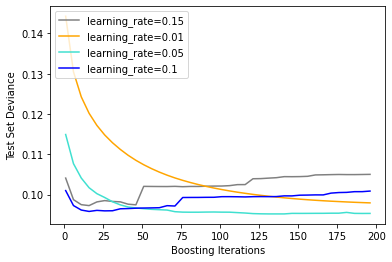

In [3]:
original_param = {'max_depth': 5, 'n_estimators': 200, 'verbose': 1}
for label, color, setting in [('learning_rate=0.15', 'gray',
                               {'learning_rate': 0.15}),
                              ('learning_rate=0.01', 'orange',
                               {'learning_rate': 0.01}),
                              ('learning_rate=0.05', 'turquoise',
                               {'learning_rate': 0.05}),
                              ('learning_rate=0.1', 'blue',
                               {'learning_rate': 0.1})]:
    params = ChainMap(setting, original_param)
    clf = GradientBoostingClassifier(**params).fit(x_train, y_train)
    test_deviance = np.zeros((params['n_estimators'],), dtype=np.float64)

    for i, y_pred in enumerate(clf.staged_decision_function(x_test)):
        # clf.loss_ assumes that y_test[i] in {0, 1}
        test_deviance[i] = clf.loss_(y_test, y_pred)

    plt.plot((np.arange(test_deviance.shape[0]) + 1)[::5], test_deviance[::5],
            '-', color=color, label=label)

plt.legend(loc='upper left')
plt.xlabel('Boosting Iterations')
plt.ylabel('Test Set Deviance')

plt.show()

learning_rate=0.025
0.5053064019171517
learning_rate=0.05
0.5296131461828141
learning_rate=0.075
0.5251626155426223


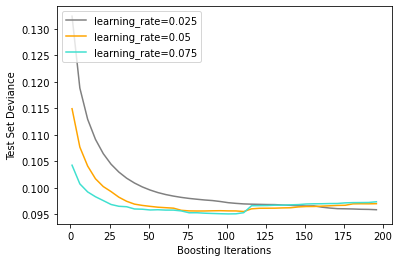

In [4]:
original_param = {'max_depth': 5, 'n_estimators': 200, 'verbose': 0}
for label, color, setting in [('learning_rate=0.025', 'gray',
                               {'learning_rate': 0.025}),
                              ('learning_rate=0.05', 'orange',
                               {'learning_rate': 0.05}),
                              ('learning_rate=0.075', 'turquoise',
                               {'learning_rate': 0.075})]:
    params = ChainMap(setting, original_param)
    clf = GradientBoostingClassifier(**params).fit(x_train, y_train)
    test_deviance = np.zeros((params['n_estimators'],), dtype=np.float64)

    for i, y_pred in enumerate(clf.staged_decision_function(x_test)):
        # clf.loss_ assumes that y_test[i] in {0, 1}
        test_deviance[i] = clf.loss_(y_test, y_pred)

    plt.plot((np.arange(test_deviance.shape[0]) + 1)[::5], test_deviance[::5],
            '-', color=color, label=label)
    print(label)
    print(fdr(clf, x_test, y_test))

plt.legend(loc='upper left')
plt.xlabel('Boosting Iterations')
plt.ylabel('Test Set Deviance')

plt.show()

subsample=0.25
0.514549811708319
subsample=0.5
0.5251626155426223
subsample=0.75
0.5323519342690859


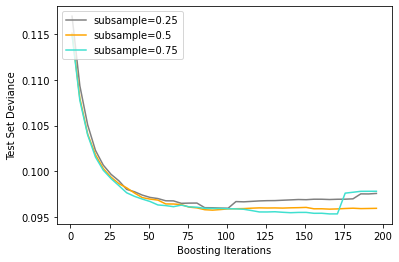

In [5]:
original_param = {'max_depth': 5, 'n_estimators': 200, 'learning_rate': 0.05, 'verbose': 0}
for label, color, setting in [('subsample=0.25', 'gray',
                               {'subsample': 0.25}),
                              ('subsample=0.5', 'orange',
                               {'subsample': 0.5}),
                              ('subsample=0.75', 'turquoise',
                               {'subsample': 0.75})]:
    params = ChainMap(setting, original_param)
    clf = GradientBoostingClassifier(**params).fit(x_train, y_train)
    test_deviance = np.zeros((params['n_estimators'],), dtype=np.float64)

    for i, y_pred in enumerate(clf.staged_decision_function(x_test)):
        # clf.loss_ assumes that y_test[i] in {0, 1}
        test_deviance[i] = clf.loss_(y_test, y_pred)

    plt.plot((np.arange(test_deviance.shape[0]) + 1)[::5], test_deviance[::5],
            '-', color=color, label=label)
    print(label)
    print(fdr(clf, x_test, y_test))

plt.legend(loc='upper left')
plt.xlabel('Boosting Iterations')
plt.ylabel('Test Set Deviance')

plt.show()

In [6]:
bt = GradientBoostingClassifier(learning_rate=0.05, subsample=0.5)
params = {'n_estimators': [50, 100, 200],
          'max_depth': [2, 5, 10]}
grid = GridSearchCV(bt, params, cv=4, refit='FDR', 
                    verbose=1, n_jobs=8,
                    scoring={'FDR': fdr, 'ROC': 'roc_auc'})
grid.fit(x_train, y_train)

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  36 out of  36 | elapsed: 14.6min finished


GridSearchCV(cv=4, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.05,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
        

In [7]:
print(f"The best parameters are {grid.best_params_} "
      f"with a score of {grid.best_score_:0.5f}")
pd.DataFrame(grid.cv_results_).filter(
    items=['param_max_depth', 'param_n_estimators', 
           'mean_test_FDR', 'std_test_FDR', 'rank_test_FDR',
           'mean_test_ROC', 'std_test_ROC'])

The best parameters are {'max_depth': 10, 'n_estimators': 100} with a score of 0.52458


,param_max_depth,param_n_estimators,mean_test_FDR,std_test_FDR,rank_test_FDR,mean_test_ROC,std_test_ROC
0,2,50,0.486750,0.014238,9,0.732502,0.005872
1,2,100,0.512378,0.014629,5,0.745836,0.005830
2,2,200,0.511332,0.013677,6,0.746861,0.005302
3,5,50,0.509937,0.013880,7,0.744745,0.005613
4,5,100,0.509850,0.010941,8,0.748583,0.005731
5,5,200,0.519613,0.011153,4,0.761162,0.007572
6,10,50,0.521269,0.009271,3,0.760917,0.007352
7,10,100,0.524582,0.011979,1,0.766024,0.008508
8,10,200,0.524059,0.010060,2,0.767939,0.008240


In [8]:
bt = GradientBoostingClassifier(max_depth=10,
                                n_estimators=100,
                                learning_rate=0.05,
                                subsample=0.5).fit(x_train, y_train)
print(fdr(bt, x_train, y_train))
print(fdr(bt, x_test, y_test))

0.530160390516039
0.5320095857583019


In [9]:
bt = GradientBoostingClassifier(max_depth=20,
                                n_estimators=100,
                                learning_rate=0.05,
                                subsample=0.5).fit(x_train, y_train)
print(fdr(bt, x_train, y_train))
print(fdr(bt, x_test, y_test))

0.6033821478382148
0.5053064019171517


In [11]:
x_train_40, x_test_40, y_train_40, y_test_40 = load_data('var_40.csv')
bt = GradientBoostingClassifier(max_depth=10,
                                n_estimators=100,
                                learning_rate=0.05,
                                subsample=0.5).fit(x_train_40, y_train_40)
print(fdr(bt, x_train_40, y_train_40))
print(fdr(bt, x_test_40, y_test_40))

0.5570083682008368
0.5535775419376926
